In [1]:
# inline plotting instead of popping out
%matplotlib inline

# python 3.7.3
import os, itertools, csv

from IPython.display import Image
from IPython.display import display

# numpy  1.17.1
import numpy as np

# pandas  0.25.1
import pandas as pd

# scikit-learn  0.21.3
from sklearn import datasets
load_iris = datasets.load_iris
make_moons = datasets.make_moons
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error, roc_curve, auc
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier

# matplotlib  3.1.1
import matplotlib.pyplot as plt

# load utility classes/functions that has been taught in previous labs
# e.g., plot_decision_regions()
from lib import *

# Make output directory
if not os.path.exists("output/") : os.mkdir("output/")

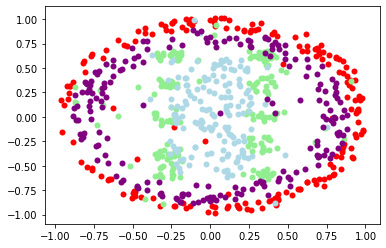

In [2]:
file = open('./train.csv', encoding='utf-8')
reader = csv.reader(file)
next(reader)
X = np.ndarray((0, 2))
y = np.ndarray((0,))
y_mapping = {'Bob': 0, 'Kate': 1, 'Mark': 2, 'Sue': 3}
i = 0
for row in reader:
  i += 1
  X = np.vstack((X, np.array(row[0:2])))
  y = np.append(y, y_mapping[row[2]])
X = X.astype(np.float)
y = y.astype(np.float)
file.close()

plt.scatter(X[y == 0, 0], X[y == 0, 1], label='Bob', c='red', linewidths=0)
plt.scatter(
    X[y == 1, 0], X[y == 1, 1], label='Kate', c='lightgreen', linewidths=0)
plt.scatter(
    X[y == 2, 0], X[y == 2, 1], label='Mark', c='lightblue', linewidths=0)
plt.scatter(X[y == 3, 0], X[y == 3, 1], label='Sue', c='purple', linewidths=0)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [ ]:
best_k, best_score = -1, -1
clfs = {}

for k in [1, 15, 50]: # experiment different hyperparameter
    pipe = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsClassifier(n_neighbors=k)]])
    pipe.fit(X_train, y_train)
    # K-Fold CV
    scores = cross_val_score(pipe, X_train, y_train, cv=5)
    print('[%d-NN]\nValidation accuracy: %.3f %s' % (k, scores.mean(), scores))
    if scores.mean() > best_score:
        best_k, best_score = k, scores.mean()
    clfs[k] = pipe

In [ ]:
best_clf = clfs[best_k]
best_clf.fit(X_train, y_train)

# performance reporting
y_pred = best_clf.predict(X_test)
print('Test accuracy: %.2f (n_neighbors=%d selected by 5-fold CV)' % 
      (accuracy_score(y_test, y_pred), best_k))

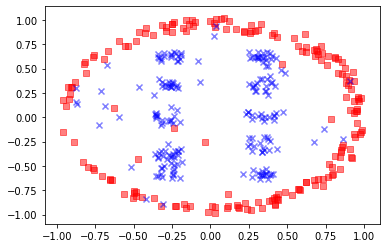

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

plt.scatter(X[y == 0, 0], X[y == 0, 1], label='Class 0',
            c='r', marker='s', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], label='Class 1',
            c='b', marker='x', alpha=0.5)
plt.scatter(X_test[:, 0], X_test[:, 1],
            c='', marker='o', label='Class 1')
plt.show()

pipe1 = Pipeline([['sc', StandardScaler()], ['clf', LogisticRegression(C = 10, random_state = 0, solver = "liblinear", multi_class='auto')]])
pipe2 = Pipeline([['clf', DecisionTreeClassifier(max_depth = 3, random_state = 0)]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsClassifier(n_neighbors = 5)]])

In [4]:
clf_labels = ['LogisticRegression', 'DecisionTree', 'KNN']
print('[Individual]')
for pipe, label in zip([pipe1, pipe2, pipe3], clf_labels):
    scores = cross_val_score(estimator=pipe, X=X_train, y=y_train, cv=10)
    print('%s: %.3f (+/- %.3f)' % (label, scores.mean(), scores.std()))

[Individual]
LogisticRegression: 0.321 (+/- 0.056)
DecisionTree: 0.500 (+/- 0.042)
KNN: 0.810 (+/- 0.052)


In [5]:
print('[Voting]')
best_vt, best_w, best_score = None, (), -1
for a, b, c in list(itertools.permutations(range(0,3))): # try some weight combination
    clf = VotingClassifier(estimators=[('lr', pipe1), ('dt', pipe2), ('knn', pipe3)], 
                           voting='soft', weights=[a,b,c])
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10)
    print('%s: %.3f (+/- %.3f)' % ((a,b,c), scores.mean(), scores.std()))
    if best_score < scores.mean():
        best_vt, best_w, best_score = clf, (a, b, c), scores.mean()

print('\nBest %s: %.3f' % (best_w, best_score))

[Voting]
(0, 1, 2): 0.812 (+/- 0.043)
(0, 2, 1): 0.741 (+/- 0.054)
(1, 0, 2): 0.807 (+/- 0.053)
(1, 2, 0): 0.500 (+/- 0.042)
(2, 0, 1): 0.783 (+/- 0.058)
(2, 1, 0): 0.492 (+/- 0.042)

Best (0, 1, 2): 0.812


In [24]:
#Use Gridsearch to fine-tune decision tree + adaboost
param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__max_depth" : [4,5,6,7,8,9,10,15]}

ada_test = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(),n_estimators=500)

# run grid search
gs = GridSearchCV(ada_test, param_grid=param_grid,cv=5)
gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.811864406779661
{'base_estimator__criterion': 'entropy', 'base_estimator__max_depth': 7}


In [25]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=7)
bag = BaggingClassifier(base_estimator=tree, n_estimators=500, 
                        max_samples=0.7, bootstrap=True,
                        max_features=1.0, bootstrap_features=False, 
                        n_jobs=1, random_state=1)

In [26]:
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('[DecisionTree] accuracy-train = %.3f, accuracy-test = %.3f' % (tree_train, tree_test))

# Bagging
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('[Bagging] auc-train = %.3f, auc-test = %.3f' % (bag_train, bag_test))

# adaboost
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500)
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('[AdaBoost] accuracy-train = %.3f, accuracy-test = %.3f' % 
      (ada_train, ada_test))



[DecisionTree] accuracy-train = 0.890, accuracy-test = 0.784
[Bagging] auc-train = 0.900, auc-test = 0.824
[AdaBoost] accuracy-train = 1.000, accuracy-test = 0.818
